### Introduction
### Machine learning model to classify the credit score based on people bank details and credit related information.

### Import the necessary packages.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
from matplotlib import pyplot as plt # visualization
%matplotlib inline
import warnings
import re
import math
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")

### Import train and test dataset

In [188]:
train=pd.read_csv("../input/he-transunion-hiringchallenge-2022/dataset/train.csv")
test=pd.read_csv("../input/he-transunion-hiringchallenge-2022/dataset/test.csv")

### Let's combine the train and test dataset before that need a column that shows whether it's from the train or test dataset.

In [189]:
train['data']='train'
test['data']='test'

In [190]:
full_data=pd.concat([train,test],axis=0)

### Pre-process function

In [191]:
def pre_process(df):
    #Convert column name to lower case letters
    df.rename(columns={col:col.lower() for col in df.columns},inplace=True)
    
    #Replace the non-numeric symbols
    df['age']=df['age'].apply(lambda x: re.sub("([\_\-])","",str(x)))
    #Convert to numeric format
    df['age']=pd.to_numeric(df['age'],errors='coerce')
    
    #Replace as null if value is greater than 100
    df['age']=df['age'].apply(lambda x: np.nan if x>100 else x)
    
    
    #Replace the non-numeric symbols
    df['ssn']=df['ssn'].apply(lambda x:x if re.match("([0-9]{3}-[0-9]{2}-[0-9]{4})", str(x)) else np.nan)
    
    #Replace the special character symbols
    df['occupation']=df['occupation'].apply(lambda x:np.nan if re.fullmatch("(_______)",str(x)) else x)
    
    #Replace the non-numeric symbols
    df['annual_income']=df['annual_income'].apply(lambda x: re.sub('([^0-9.])','',str(x)))
    #Convert column to float data type
    df['annual_income']=df['annual_income'].astype('float')
    
    #Replace as null if the value greater than 11 or less than 0
    df['num_bank_accounts']=df['num_bank_accounts'].apply(lambda x: np.nan if ((x<0)|(x>11)) else x)
    #Replace as null if the value is not less than 12
    df['num_credit_card']=df['num_credit_card'].apply(lambda x:x if x<12 else np.nan)
    
    #Replace as null if the value is not less than 35
    df['interest_rate']=df['interest_rate'].apply(lambda x:x if x<35 else np.nan)
    
    #Replace the non-numeric symbols
    df['num_of_loan']=df['num_of_loan'].apply(lambda x: re.sub('([\_\-]+)','',str(x)))
    #Convert to numeric format
    df['num_of_loan']=pd.to_numeric(df['num_of_loan'],errors='coerce')
    #Replace as 10 if the value is 100
    df['num_of_loan']=df['num_of_loan'].apply(lambda x:10 if x==100 else x)
    #Replace as null if the value is not less than 11
    df['num_of_loan']=df['num_of_loan'].apply(lambda x:x if x<11 else np.nan)
    
    #Replace the non-numeric symbols
    df['num_of_delayed_payment']=df['num_of_delayed_payment'].apply(lambda x:re.sub("[\_\-]","",str(x)))
    #Convert to numeric type
    df['num_of_delayed_payment']=pd.to_numeric(df['num_of_delayed_payment'],errors='coerce',downcast='integer')
    #Replace as null if the value is not less than 29
    df['num_of_delayed_payment']=df['num_of_delayed_payment'].apply(lambda x:x if x<29 else np.nan)
    
    #Replace the non-numeric symbols
    df['changed_credit_limit']=df['changed_credit_limit'].apply(lambda x: re.sub("([\-\_])","",str(x)))
    #Convert to numeric type
    df['changed_credit_limit']=pd.to_numeric(df['changed_credit_limit'],errors='coerce')
    df['changed_credit_limit']=round(df['changed_credit_limit'],2)
    
    #Replace as null if the value is not less than 18
    df['num_credit_inquiries']=df['num_credit_inquiries'].apply(lambda x:x if x<18 else np.nan)
    
    #Replace the special character symbols
    df['credit_mix']=df['credit_mix'].apply(lambda x: np.nan if re.match("([_]+)",str(x)) else x)
    
    #Replace the non-numeric symbols
    df['outstanding_debt']=df['outstanding_debt'].apply(lambda x:re.sub("([\_])","",str(x)))
    #Convert to numeric type
    df['outstanding_debt']=df['outstanding_debt'].astype('float')
    
    #function to extract year and month from tex and number mixed rows
    def credit_hist_age(col):
        if re.match("(\d+)\s\w+\s\w+\s\d+\s\w+",col):
            year="".join(re.findall("(\d+)\s\w+\s\w+\s\d+\s\w+",col))
            months="".join(re.findall("\d+\s\w+\s\w+\s(\d+)\s\w+",col))
            return f"{year}.{months }"
    
    #Extract the year and month by using above function
    df['credit_history_age']=df['credit_history_age'].apply(lambda x:credit_hist_age(str(x)))
    #Convert to numeric type
    df['credit_history_age']=df['credit_history_age'].astype('float')
    
    #Replace the non-numeric symbols
    df['amount_invested_monthly']=df['amount_invested_monthly'].apply(lambda x:re.sub("(\_)","",str(x))).astype('float')
    df['amount_invested_monthly']=round(df['amount_invested_monthly'],2)
    
    #Replace the special character symbols
    df['payment_behaviour']=df['payment_behaviour'].apply(lambda x: re.sub("([^a-zA-z]+)","",str(x)))
    df['payment_behaviour']=df['payment_behaviour'].apply(lambda x: np.nan if len(x)==0 else x)
    
    #Replace the non-numeric symbols
    df['monthly_balance']=df['monthly_balance'].apply(lambda x: re.sub("([\_]+)","",str(x)))
    #Convert to numeric type
    df['monthly_balance']=df['monthly_balance'].astype('float')
    df['monthly_balance']=round(df['monthly_balance'],2)
    
    
    #Create a missing row indicator for the columns which have missing values.
    for i in df.columns[df.isnull().any()].values:
        df[f"{i}_isnull"]=df[i].isnull().astype('int')
    
    #Replace age column value by mean
    df['age']=df['age'].fillna(df.groupby('customer_id')['age'].transform('mean'))
    
    #Create unique ssn dataframe for customer
    ssn_unique_df=df.groupby(['customer_id','ssn'])['ssn'].agg({'count'}).reset_index().iloc[:,:2]
    
    
    #drop ssn
    df=df.drop(columns=['ssn'])

    #left join to main dataframe
    df=pd.merge(df,ssn_unique_df,on='customer_id',how='left')
    
    
    #occupation
    occupation_uni_df=df.groupby(['customer_id','occupation'])['occupation'].agg({'count'}).reset_index().iloc[:,:2]

    #drop occupation
    df=df.drop(columns=['occupation'])

    #left join to main dataframe
    df=pd.merge(df,occupation_uni_df,on='customer_id',how='left')
    
    #monthly_inhand_salary column missing value replacement
    df['monthly_inhand_salary']=df['monthly_inhand_salary'].fillna(df.groupby('customer_id')['monthly_inhand_salary'].transform('mean'))
    
    #num_bank_accounts column missing value replacement
    df['num_bank_accounts']=df['num_bank_accounts'].fillna(df.groupby('customer_id')['num_bank_accounts'].transform('median'))
    
    #num_credit_card column missing value replacement
    df['num_credit_card']=df['num_credit_card'].fillna(df.groupby('customer_id')['num_credit_card'].transform('median'))
    
    #interest_rate column missing value replacement
    df['interest_rate']=df['interest_rate'].fillna(df.groupby('customer_id')['interest_rate'].transform('mean'))
    
    #num_of_loan column missing value replacement
    df['num_of_loan']=df['num_of_loan'].fillna(df.groupby('customer_id')['num_of_loan'].transform('median'))
    
    #type_of_loan
    type_of_loan_uni_df=df.groupby(['customer_id','type_of_loan'])['type_of_loan'].agg({'count'}).reset_index().iloc[:,:2]
    
    #drop type_of_loan
    df=df.drop(columns=['type_of_loan'])

    #left join to main dataframe
    df=pd.merge(df,type_of_loan_uni_df,on='customer_id',how='left')
    
    
    #type_of_loan column missing value replacement
    df['type_of_loan']=df['type_of_loan'].fillna('Not Specified')
    
    
    #num_of_delayed_payment column missing value replacement
    df['num_of_delayed_payment']=df['num_of_delayed_payment'].fillna(df.groupby('customer_id')['num_of_delayed_payment'].transform('median'))
    
    #changed_credit_limit column missing value replacement
    df['changed_credit_limit']=df['changed_credit_limit'].fillna(df.groupby('customer_id')['changed_credit_limit'].transform('mean'))
    
    #num_credit_inquiries column missing value replacement
    df['num_credit_inquiries']=df['num_credit_inquiries'].fillna(df.groupby('customer_id')['num_credit_inquiries'].transform('mean'))
    
    #credit_mix
    credit_mix_uni_df=df.groupby(['customer_id','credit_mix'])['credit_mix'].agg({'count'}).reset_index().iloc[:,:2]
    
    #drop credit_mix
    df=df.drop(columns=['credit_mix'])

    #left join to main dataframe
    df=pd.merge(df,credit_mix_uni_df,on='customer_id',how='left')
    
    #credit_hit_age column missing value replacement
    df['credit_history_age']=df['credit_history_age'].fillna(df.groupby('customer_id')['credit_history_age'].transform('mean'))
   
  
    #amount_invested_monthly column missing value replacement
    df['amount_invested_monthly']=df['amount_invested_monthly'].fillna(df.groupby('customer_id')['amount_invested_monthly'].transform('mean'))
    
    
    #payment_behaviour column missing value replacement
    df['payment_behaviour']= df['payment_behaviour'].fillna('other')
    
    #monthly_balance column missing value replacement
    df['monthly_balance']=df['monthly_balance'].fillna(df.groupby('customer_id')['monthly_balance'].transform('mean'))
    
    
    #define tfidf vectorizer
    v = TfidfVectorizer(stop_words ='english')
    
    #fit to the type of loan column
    x = v.fit_transform(df['type_of_loan'])
    
    #create dataframe from transformed array
    loan_type_vec=pd.DataFrame(x.toarray(),columns=v.get_feature_names())
    
    #left join to main dataframe
    df=pd.merge(df,loan_type_vec,on=df.index,how='left')
    
    return df

### Apply the pre-process steps to full_data

In [192]:
full_data=pre_process(full_data)

### Split train and test data from full_data

In [194]:
train1=full_data[full_data['data']=='train']
test1=full_data[full_data['data']=='test']

In [10]:
from sklearn.model_selection import  cross_val_score,KFold,train_test_split,RepeatedStratifiedKFold,StratifiedKFold,learning_curve
from catboost import CatBoostClassifier,Pool,cv,monoforest
import optuna
from optuna.samplers import RandomSampler,TPESampler,MOTPESampler,CmaEsSampler
from sklearn.metrics import f1_score,classification_report,confusion_matrix,roc_auc_score,accuracy_score
from xgboost import XGBClassifier,plot_tree
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback,LightGBMPruningCallback
from sklearn.preprocessing import LabelEncoder,StandardScaler,PolynomialFeatures
import lightgbm as lgbm
import math

In [206]:
for i,col in enumerate(train1.columns.values):
    print(f"{i}_{col}")

0_key_0
1_id
2_customer_id
3_month
4_name
5_age
6_annual_income
7_monthly_inhand_salary
8_num_bank_accounts
9_num_credit_card
10_interest_rate
11_num_of_loan
12_delay_from_due_date
13_num_of_delayed_payment
14_changed_credit_limit
15_num_credit_inquiries
16_outstanding_debt
17_credit_utilization_ratio
18_credit_history_age
19_payment_of_min_amount
20_total_emi_per_month
21_amount_invested_monthly
22_payment_behaviour
23_monthly_balance
24_credit_score
25_data
26_name_isnull
27_age_isnull
28_ssn_isnull
29_occupation_isnull
30_monthly_inhand_salary_isnull
31_num_bank_accounts_isnull
32_num_credit_card_isnull
33_interest_rate_isnull
34_num_of_loan_isnull
35_type_of_loan_isnull
36_num_of_delayed_payment_isnull
37_changed_credit_limit_isnull
38_num_credit_inquiries_isnull
39_credit_mix_isnull
40_credit_history_age_isnull
41_amount_invested_monthly_isnull
42_payment_behaviour_isnull
43_monthly_balance_isnull
44_credit_score_isnull
45_ssn
46_occupation
47_type_of_loan
48_credit_mix
49_auto
50

### Define target label encoder

In [196]:
lbl=LabelEncoder()

### Fit the label encoder to the target column **credit_score**.

In [197]:
train1['credit_score']=lbl.fit_transform(train1['credit_score'])

### Split predictor and response columns.

In [198]:
X=train1.iloc[:,np.r_[3,5:24,26:62]]
y=train1['credit_score']

### Split the train and validation set

In [82]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=45,stratify=y)

In [83]:
X1=X_train
y1=y_train

In [199]:
X.select_dtypes(include='object').columns

Index(['month', 'payment_of_min_amount', 'payment_behaviour', 'ssn',
       'occupation', 'type_of_loan', 'credit_mix'],
      dtype='object')

### Catboost classifier model with optuna tuning.

In [84]:
def objective(trial):
    skf = StratifiedKFold(n_splits=5,random_state=45,shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(X1,y1)):
        X_train, X_valid = X1.iloc[train_index], X1.iloc[test_index]
        y_train, y_valid = y1.iloc[train_index], y1.iloc[test_index]
        param = {

            'reg_lambda':trial.suggest_float('reg_lambda',1e-8, 1.0),
            'learning_rate': trial.suggest_float('learning_rate',1e-8, 1.0),
            'n_estimators': trial.suggest_int('n_estimators',100,1000),
            'max_depth': trial.suggest_int('max_depth', 2,12),
            'random_state': trial.suggest_categorical('random_state', [1024, 1048,2020]),
           # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
            "boosting_type": trial.suggest_categorical("boosting_type", [#"Ordered", 
                "Plain"]),
            "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", #"MVS"
                              ]
            ),
            }
        if param["bootstrap_type"] == "Bayesian":
            param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif param["bootstrap_type"] == "Bernoulli":
            param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

        cat_clf = CatBoostClassifier(early_stopping_rounds=30, grow_policy = 'Lossguide',
                                   logging_level="Silent",task_type='GPU',
                                  **param)
        cat_clf.fit(X_train, y_train,cat_features=['month', 'payment_of_min_amount', 'payment_behaviour', 'ssn',
       'occupation', 'type_of_loan', 'credit_mix']
                   )
        preds = cat_clf.predict_proba(X_test)
        accuracy = roc_auc_score(y_test, preds,average='weighted',multi_class='ovr')
        return accuracy



if __name__ == "__main__":
    study = optuna.create_study(direction='maximize',sampler=MOTPESampler(),
           pruner=optuna.pruners.SuccessiveHalvingPruner())
    study.optimize(objective, n_trials=100)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)  

[I 2022-06-19 15:31:19,425] A new study created in memory with name: no-name-8469f207-dba8-4000-9806-b12c20c5cc12
[I 2022-06-19 15:31:29,348] Trial 0 finished with value: 0.8482603686244845 and parameters: {'reg_lambda': 0.5786653469373932, 'learning_rate': 0.9998193435245425, 'n_estimators': 327, 'max_depth': 10, 'random_state': 1048, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.9689567200489386}. Best is trial 0 with value: 0.8482603686244845.
[I 2022-06-19 15:31:44,322] Trial 1 finished with value: 0.868508842985833 and parameters: {'reg_lambda': 0.7320742397936378, 'learning_rate': 0.5735940935085522, 'n_estimators': 881, 'max_depth': 4, 'random_state': 1024, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.0944413228011527}. Best is trial 1 with value: 0.868508842985833.
[I 2022-06-19 15:31:47,483] Trial 2 finished with value: 0.8483893934402997 and parameters: {'reg_lambda': 0.8789352525116303, 'learning_rate': 0

Number of finished trials: 100
Best trial: {'reg_lambda': 0.7111294774045509, 'learning_rate': 0.2838128681466268, 'n_estimators': 998, 'max_depth': 12, 'random_state': 1024, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'subsample': 0.964246805478542}


In [154]:
#best param 
param={'reg_lambda': 0.9138676838297956, 'learning_rate': 0.08135287540629096,
      'n_estimators': 887, 'max_depth': 10, 'random_state': 2020, 'boosting_type': 'Plain', 
      'bootstrap_type': 'Bernoulli', 'subsample': 0.9414567528861059}

### Create a catboost model with tuned parameters and fit the model.

In [200]:
cat_clf = CatBoostClassifier(early_stopping_rounds=30,task_type='GPU',**param)
cat_clf.fit(X, y,cat_features=['month', 'payment_of_min_amount', 'payment_behaviour', 'ssn',
       'occupation', 'type_of_loan', 'credit_mix']
       )

0:	learn: 1.0362591	total: 49.4ms	remaining: 43.8s
1:	learn: 0.9857723	total: 97.4ms	remaining: 43.1s
2:	learn: 0.9438385	total: 146ms	remaining: 43.2s
3:	learn: 0.9077940	total: 201ms	remaining: 44.3s
4:	learn: 0.8768554	total: 246ms	remaining: 43.3s
5:	learn: 0.8502230	total: 297ms	remaining: 43.6s
6:	learn: 0.8272770	total: 344ms	remaining: 43.2s
7:	learn: 0.8072548	total: 400ms	remaining: 44s
8:	learn: 0.7773320	total: 445ms	remaining: 43.4s
9:	learn: 0.7512180	total: 489ms	remaining: 42.9s
10:	learn: 0.7288141	total: 538ms	remaining: 42.8s
11:	learn: 0.7090572	total: 582ms	remaining: 42.4s
12:	learn: 0.6918898	total: 627ms	remaining: 42.2s
13:	learn: 0.6769500	total: 673ms	remaining: 42s
14:	learn: 0.6637055	total: 716ms	remaining: 41.6s
15:	learn: 0.6517837	total: 763ms	remaining: 41.5s
16:	learn: 0.6413857	total: 807ms	remaining: 41.3s
17:	learn: 0.6321228	total: 853ms	remaining: 41.2s
18:	learn: 0.6235105	total: 897ms	remaining: 41s
19:	learn: 0.6157327	total: 942ms	remaining: 

### Import shap for model explanation

In [92]:
!pip install -q shap

In [94]:
import shap

In [207]:
explainer = shap.TreeExplainer(cat_clf)
shap_values = explainer.shap_values(Pool(X, y, cat_features=['month', 'payment_of_min_amount', 'payment_behaviour', 'ssn',
       'occupation', 'type_of_loan', 'credit_mix']))

### Feature importance plot.

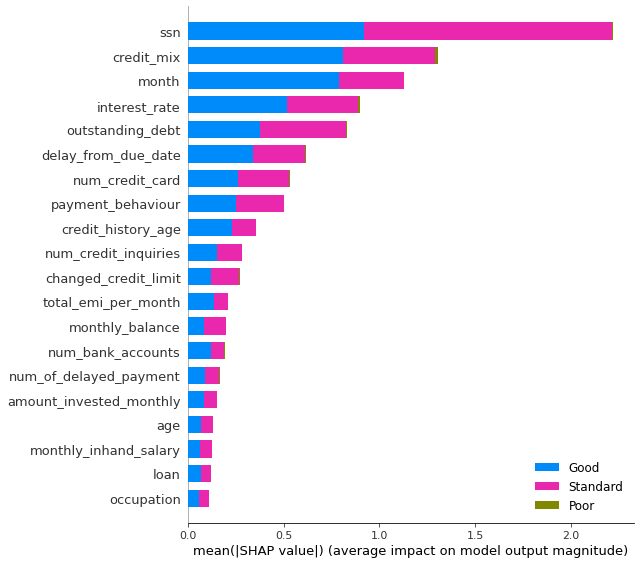

In [208]:
shap.summary_plot(shap_values, X, plot_type="bar",max_display=20,class_names=['Good', 'Standard', 'Poor'])

### Top features impact the model


For Good_0



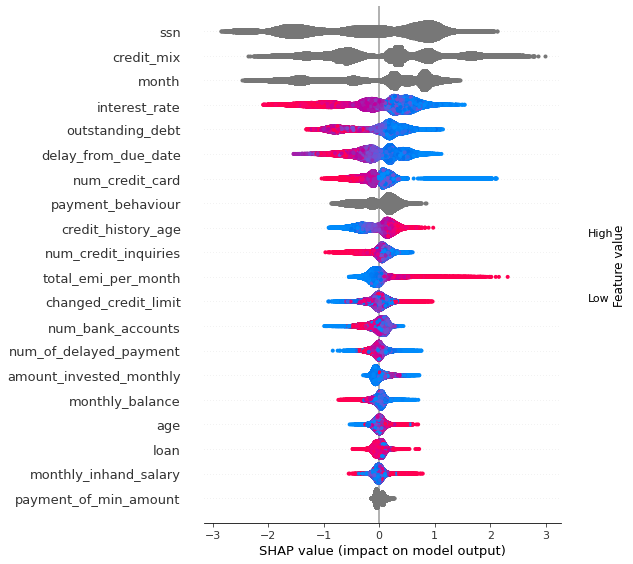


For Standard_1



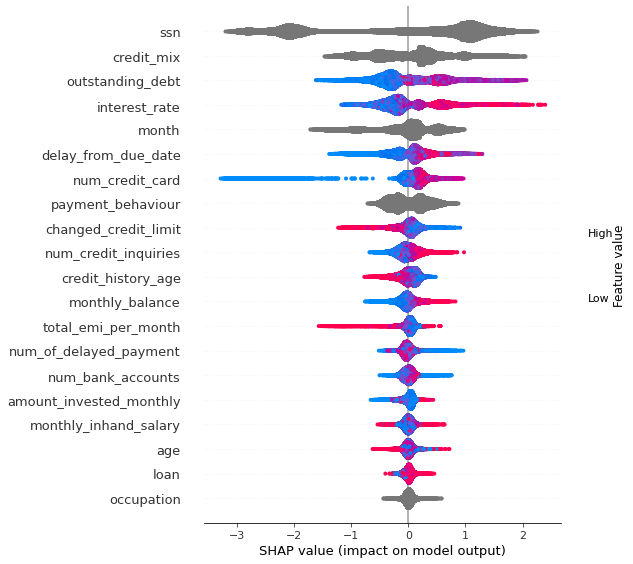


For Poor_2



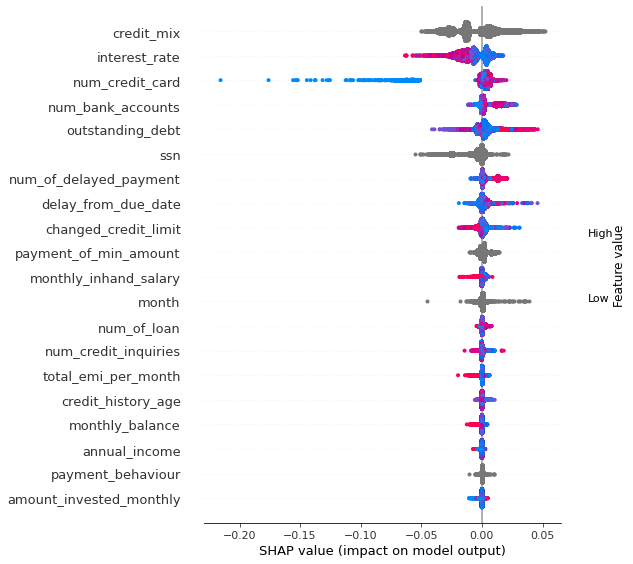

In [209]:
for i,col in enumerate(['Good', 'Standard', 'Poor']):
    print(f"\nFor {col}_{i}\n")
    shap.summary_plot(shap_values[i], X.values, feature_names = X.columns)

### Let's see which feature influences the model prediction for a single observation in each class. 


For Good_0



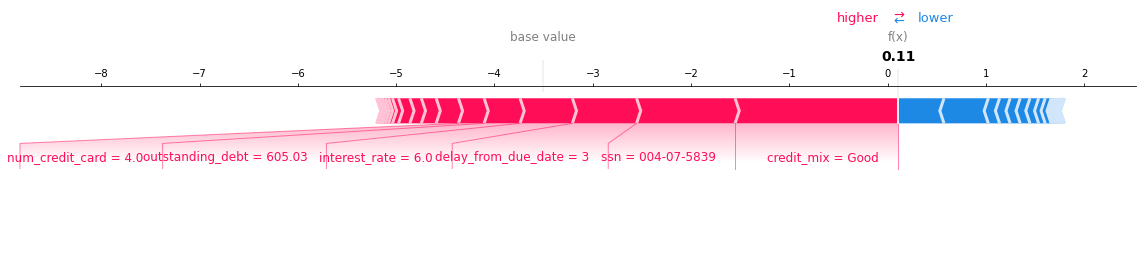


For Standard_1



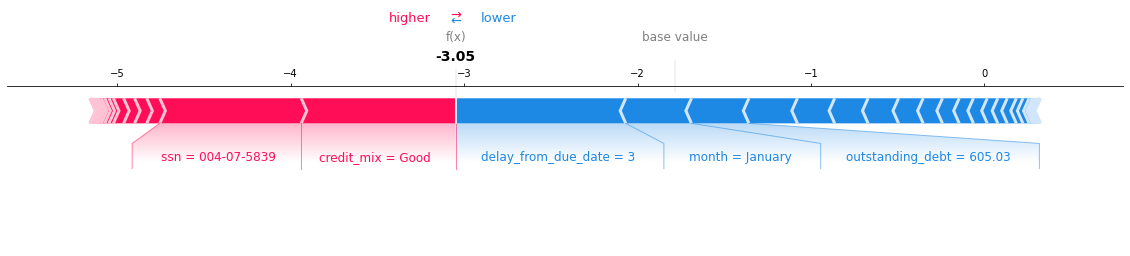


For Poor_2



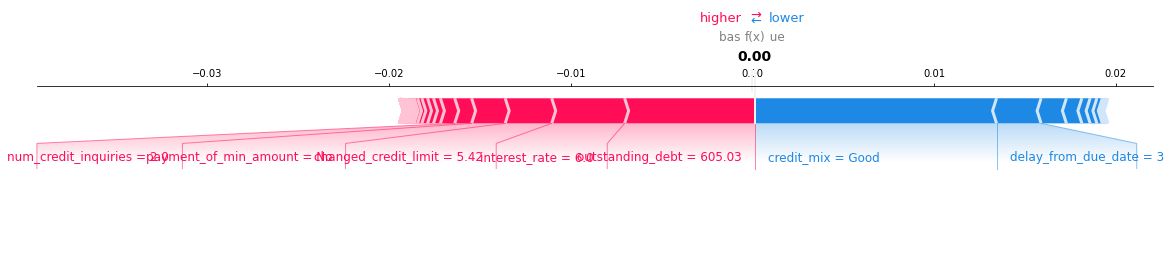

In [210]:
for i,col in enumerate(['Good', 'Standard', 'Poor']):
    row=8
    print(f"\nFor {col}_{i}\n")
    shap.force_plot(explainer.expected_value[i], shap_values[i][row], X.values[row],
                feature_names = X.columns,matplotlib=True)

### Predict the test data

In [201]:
pred =cat_clf.predict(test1.loc[:,X.columns])

### Create result dataframe.

In [202]:
res=pd.DataFrame({'ID':test1['id'],'Credit_Score':pred.ravel()})

### Inverse transform the prediction using the previously defined lbl encoder.

In [203]:
res['Credit_Score']=lbl.inverse_transform(res['Credit_Score'])

### Write dataframe to csv

In [204]:
res.to_csv("catboost_with_optuna_tuning_final__5.csv",index=False)